In [13]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.9.2 umap==0.5.5 numpy==1.24.3 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [14]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    'data/filtered_gene_bc_matrices/hg19',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('../write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


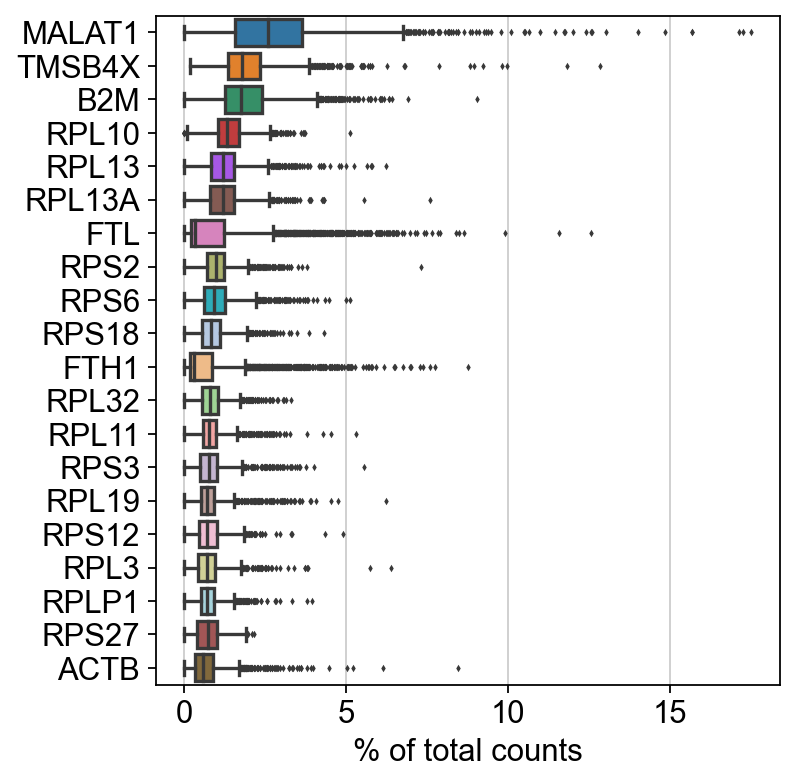

In [15]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [16]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


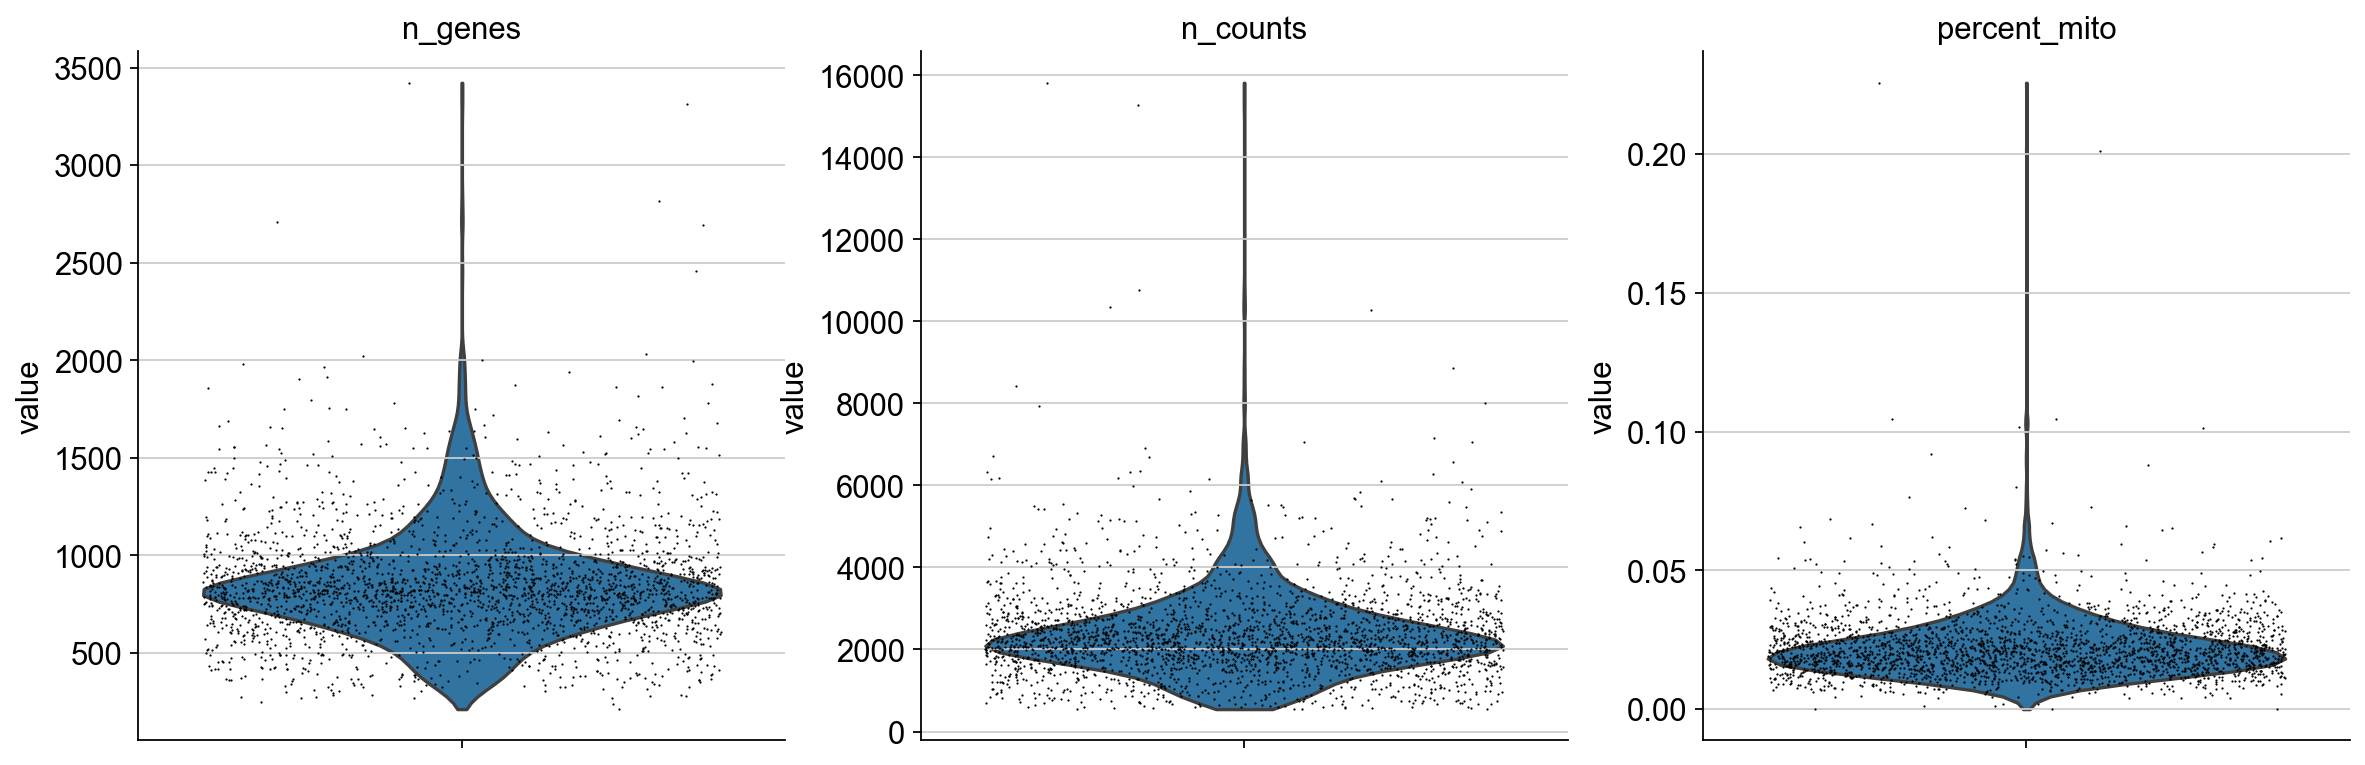

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [17]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [18]:
adata.layers["counts"] = adata.X.copy() # preserve counts
adata.X = adata.layers["counts"].copy() # use counts for normalization and dimensionality reduction
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'counts'

In [19]:
# Store the raw data
adata.raw = adata

In [20]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


ImportError: Please install skmisc package via `pip install --user scikit-misc

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'counts'

## Dimension Reduction

### DCA

In [11]:
# import dca libraries
from dca.api import dca

In [12]:
help(dca)

Help on function dca in module dca.api:

dca(adata, mode='denoise', ae_type='nb-conddisp', normalize_per_cell=True, scale=True, log1p=True, hidden_size=(64, 32, 64), hidden_dropout=0.0, batchnorm=True, activation='relu', init='glorot_uniform', network_kwds={}, epochs=300, reduce_lr=10, early_stop=15, batch_size=32, optimizer='RMSprop', learning_rate=None, random_state=0, threads=None, verbose=False, training_kwds={}, return_model=False, return_info=False, copy=False, check_counts=True)
    Deep count autoencoder(DCA) API.
    
    Fits a count autoencoder to the count data given in the anndata object
    in order to denoise the data and capture hidden representation of
    cells in low dimensions. Type of the autoencoder and return values are
    determined by the parameters.
    
    Parameters
    ----------
    adata : :class:`~scanpy.api.AnnData`
        An anndata file with `.raw` attribute representing raw counts.
    mode : `str`, optional. `denoise`(default), or `latent`.
     

In [39]:
# Apply DCA
adata = dca(adata, verbose = True)

TypeError: 'module' object is not callable

In [25]:
# Plot the results
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)





computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=10
    finished (0:00:00)


/Users/mehakrafiq/miniconda3/envs/scVAE/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [ ]:
# Save the data
adata.write('../write/pbmc3k_dca.h5ad', compression='gzip')

In [37]:
# read the written file back to adata
adata = sc.read_h5ad('../write/pbmc3k_dca.h5ad')

In [38]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts', 'dca_split', 'size_factors'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [ ]:
# Extract the latent space representation
latent_representation = adata.obsm['X_dca']

# Convert latent representation to a DataFrame
latent_df = pd.DataFrame(latent_representation, index=adata.obs_names, columns=[f'latent_dim{i+1}' for i in range(10)])

# Save to CSV file
latent_df.to_csv('dca_latent_representation.csv')